# Modelado Predictivo y Segmentación – Proyecto Telco Customer Churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Importamos los datos de training y test del archivo anterior y hacemos copias para evitar problemas de solo lectura

In [2]:
with open("train_test_data.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [3]:
# Fuerzo copias "normales" para evitar problemas de solo-lectura
X_train = X_train.copy()
X_test  = X_test.copy()
y_train = y_train.copy()
y_test  = y_test.copy()

## Aplicamos SMOTE para balancear los datos. teniamos demasiados 0 respecto de 1 en la variable explicada

In [4]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Antes SMOTE:\n", y_train.value_counts())
print("\nDespués SMOTE:\n", y_train_sm.value_counts())
print("\nShapes:", X_train.shape, "->", X_train_sm.shape)


C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, a

Antes SMOTE:
 Churn Value
0    3622
1    1308
Name: count, dtype: int64

Después SMOTE:
 Churn Value
0    3622
1    3622
Name: count, dtype: int64

Shapes: (4930, 23) -> (7244, 23)


### Entrenamos al modelo con los datos de training y test ya balanceados. calculamos matriz de confusión y otros indicadores de la calidad de nuestro modelo

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    accuracy_score,
    recall_score
)

log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamos con SMOTE (train balanceado)
log_reg.fit(X_train_sm, y_train_sm)

# Predicciones en TEST (sin SMOTE)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Accuracy ===")
print(accuracy_score(y_test, y_pred))

print("\n=== Sensibilidad y especificidad ===")
print(f"Sensibilidad (recall clase 1): {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Especificidad (recall clase 0): {recall_score(y_test, y_pred, pos_label=0):.4f}")

print("\n=== ROC-AUC ===")
print(roc_auc_score(y_test, y_proba))

print("\n=== Classification report ===")
print(classification_report(y_test, y_pred))



=== Matriz de confusión ===
[[1277  275]
 [ 176  385]]

=== Accuracy ===
0.7865593942262187

=== Sensibilidad y especificidad ===
Sensibilidad (recall clase 1): 0.6863
Especificidad (recall clase 0): 0.8228

=== ROC-AUC ===
0.8375840729918957

=== Classification report ===
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1552
           1       0.58      0.69      0.63       561

    accuracy                           0.79      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.80      0.79      0.79      2113



C:\tools\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
proba_df = pd.DataFrame({
    "prob_churn": y_proba,
    "churn_real": y_test.values,
    "churn_predicho": y_pred
})

# Opcional: ordenar de mayor a menor probabilidad de churn
proba_df_sorted = proba_df.sort_values("prob_churn", ascending=False)

proba_df_sorted.head(10)


,prob_churn,churn_real,churn_predicho
1862,0.955168,1,1
917,0.952873,1,1
1377,0.928487,1,1
1716,0.927404,1,1
1879,0.926574,1,1
1388,0.925243,1,1
1243,0.922651,1,1
266,0.918679,1,1
832,0.917633,1,1
236,0.915991,1,1


### Graficamos matriz de confusión y curva de ROC

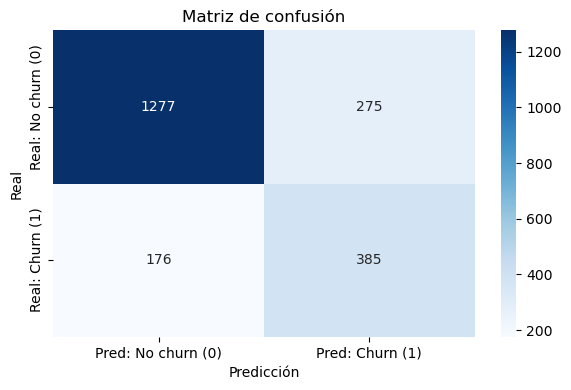

In [7]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Pred: No churn (0)", "Pred: Churn (1)"],
    yticklabels=["Real: No churn (0)", "Real: Churn (1)"]
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()


#### 1277 → clientes que no abandonan y el modelo dice que no abandonan
#### 275 → clientes que no abandonan, pero el modelo dice que sí abandonan
#### 176 → clientes que sí abandonan, pero el modelo dice que no abandonan
#### 385 → clientes que sí abandonan y el modelo dice que sí abandonan

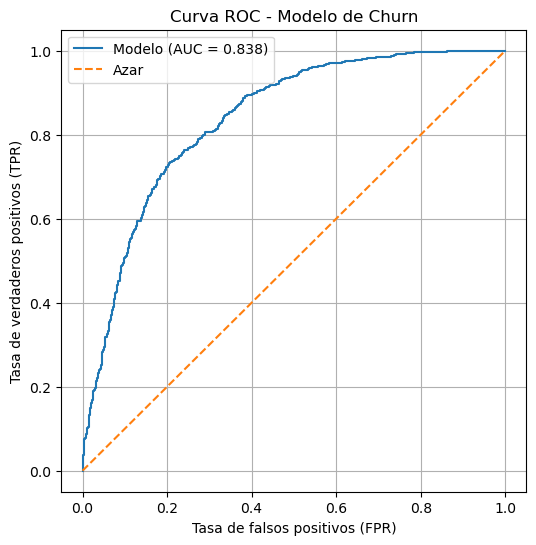

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Modelo (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Modelo de Churn")
plt.legend()
plt.grid(True)
plt.show()


## Tratamiento del Umbral
#### Tenemos un umbral 0.5 por defecto. ajustaremos para ver si mejora el modelo

In [9]:
from sklearn.metrics import accuracy_score

def evaluar_umbral(threshold):
    y_pred_th = (y_proba >= threshold).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_th)
    acc = accuracy_score(y_test, y_pred_th)
    
    tn, fp, fn, tp = cm.ravel()
    
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\n=== Umbral = {threshold:.2f} ===")
    print("Matriz de confusión:")
    print(cm)
    print(f"Accuracy:      {acc:.3f}")
    print(f"Sensibilidad:  {sensibilidad:.3f}  (recall clase churn)")
    print(f"Especificidad: {especificidad:.3f}  (recall clase no churn)")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

for thr in [0.50, 0.40, 0.30]:
    evaluar_umbral(thr)




=== Umbral = 0.50 ===
Matriz de confusión:
[[1277  275]
 [ 176  385]]
Accuracy:      0.787
Sensibilidad:  0.686  (recall clase churn)
Especificidad: 0.823  (recall clase no churn)
ROC-AUC: 0.8375840729918957

=== Umbral = 0.40 ===
Matriz de confusión:
[[1197  355]
 [ 141  420]]
Accuracy:      0.765
Sensibilidad:  0.749  (recall clase churn)
Especificidad: 0.771  (recall clase no churn)
ROC-AUC: 0.8375840729918957

=== Umbral = 0.30 ===
Matriz de confusión:
[[1089  463]
 [ 109  452]]
Accuracy:      0.729
Sensibilidad:  0.806  (recall clase churn)
Especificidad: 0.702  (recall clase no churn)
ROC-AUC: 0.8375840729918957


### voy a optar por 0.30, ya que de este modo puedo predecir el 80% de los clientes que se van, que es para mi la prioridad.
### pago un precio, que es preocuparme por un porcentaje mayor de clientes que no se iban, pero en mi opinion es un coste aceptable para no perder de vista a los que se van. sobre todo teniendo en cuenta que los que se van son los clientes que mas gastan, como me decia el mapa de calor Monthly Charges - Tenure Months

In [10]:
umbral = 0.30

# Probabilidades ya calculadas antes
# y_proba = log_reg.predict_proba(X_test)[:, 1]

y_pred_logreg_030 = (y_proba >= umbral).astype(int)

cm_logreg_030 = confusion_matrix(y_test, y_pred_logreg_030)
acc_logreg_030 = accuracy_score(y_test, y_pred_logreg_030)

print("Matriz de confusión (Logística, umbral 0.30):")
print(cm_logreg_030)
print("Accuracy:", acc_logreg_030)


Matriz de confusión (Logística, umbral 0.30):
[[1089  463]
 [ 109  452]]
Accuracy: 0.7292948414576431


## MODELO ALTERNATIVO: Arbol de decision

### planteamos un modelo de arbol para compararlo con nuestro modelo logistico y ver cual es mejor

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Árbol relativamente poco profundo para empezar (interpretabilidad)
tree_clf = DecisionTreeClassifier(
    max_depth=5,       # luego podemos probar otros valores
    random_state=42
)

# Entrenamos
tree_clf.fit(X_train_sm, y_train_sm)

# Probabilidades de churn del árbol
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

# Predicción con el MISMO umbral 0.30
y_pred_tree_030 = (y_proba_tree >= umbral).astype(int)

# ROC-AUC del árbol
auc_tree = roc_auc_score(y_test, y_proba_tree)
print("ROC-AUC Árbol (max_depth=5):", auc_tree)


ROC-AUC Árbol (max_depth=5): 0.8069893140011393


In [12]:
cm_tree_030 = confusion_matrix(y_test, y_pred_tree_030)
acc_tree_030 = accuracy_score(y_test, y_pred_tree_030)

tn, fp, fn, tp = cm_tree_030.ravel()
sens_tree = tp / (tp + fn)
esp_tree  = tn / (tn + fp)

print("\nMatriz de confusión (Árbol, umbral 0.30):")
print(cm_tree_030)
print("Accuracy:", acc_tree_030)
print("Sensibilidad (churn):", sens_tree)
print("Especificidad (no churn):", esp_tree)



Matriz de confusión (Árbol, umbral 0.30):
[[1034  518]
 [  87  474]]
Accuracy: 0.7136772361571225
Sensibilidad (churn): 0.8449197860962567
Especificidad (no churn): 0.6662371134020618


In [13]:
depths = [3, 4, 5, 6, 7, 8, 10]

for d in depths:
    tree = DecisionTreeClassifier(
        max_depth=d,
        random_state=42
    )
    tree.fit(X_train, y_train)
    
    y_proba_d = tree.predict_proba(X_test)[:, 1]
    y_pred_d = (y_proba_d >= umbral).astype(int)   # umbral = 0.30
    
    auc_d = roc_auc_score(y_test, y_proba_d)
    cm = confusion_matrix(y_test, y_pred_d)
    tn, fp, fn, tp = cm.ravel()
    
    sens = tp / (tp + fn)
    esp  = tn / (tn + fp)
    acc  = accuracy_score(y_test, y_pred_d)
    
    print(f"\n=== max_depth = {d} ===")
    print(f"AUC: {auc_d:.3f}  |  Accuracy: {acc:.3f}")
    print(f"Sensibilidad (churn): {sens:.3f}")
    print(f"Especificidad (no churn): {esp:.3f}")



=== max_depth = 3 ===
AUC: 0.796  |  Accuracy: 0.694
Sensibilidad (churn): 0.816
Especificidad (no churn): 0.649

=== max_depth = 4 ===
AUC: 0.820  |  Accuracy: 0.763
Sensibilidad (churn): 0.736
Especificidad (no churn): 0.773

=== max_depth = 5 ===
AUC: 0.830  |  Accuracy: 0.750
Sensibilidad (churn): 0.758
Especificidad (no churn): 0.747

=== max_depth = 6 ===
AUC: 0.821  |  Accuracy: 0.756
Sensibilidad (churn): 0.754
Especificidad (no churn): 0.756

=== max_depth = 7 ===
AUC: 0.808  |  Accuracy: 0.757
Sensibilidad (churn): 0.770
Especificidad (no churn): 0.752

=== max_depth = 8 ===
AUC: 0.778  |  Accuracy: 0.743
Sensibilidad (churn): 0.688
Especificidad (no churn): 0.762

=== max_depth = 10 ===
AUC: 0.736  |  Accuracy: 0.728
Sensibilidad (churn): 0.643
Especificidad (no churn): 0.759


In [14]:
# Árbol definitivo
tree_best = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

tree_best.fit(X_train_sm, y_train_sm)

# Probabilidades y predicción con umbral 0.30 (mismo que logística)
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]
y_pred_tree_030 = (y_proba_tree >= umbral).astype(int)

# Métricas
auc_tree = roc_auc_score(y_test, y_proba_tree)
cm_tree  = confusion_matrix(y_test, y_pred_tree_030)
acc_tree = accuracy_score(y_test, y_pred_tree_030)

tn, fp, fn, tp = cm_tree.ravel()
sens_tree = tp / (tp + fn)
esp_tree  = tn / (tn + fp)

print("ROC-AUC Árbol:", auc_tree)
print("Matriz de confusión (Árbol, umbral 0.30):")
print(cm_tree)
print("Accuracy:", acc_tree)
print("Sensibilidad (churn):", sens_tree)
print("Especificidad (no churn):", esp_tree)


ROC-AUC Árbol: 0.8069893140011393
Matriz de confusión (Árbol, umbral 0.30):
[[1034  518]
 [  87  474]]
Accuracy: 0.7136772361571225
Sensibilidad (churn): 0.8449197860962567
Especificidad (no churn): 0.6662371134020618


<Figure size 500x500 with 0 Axes>

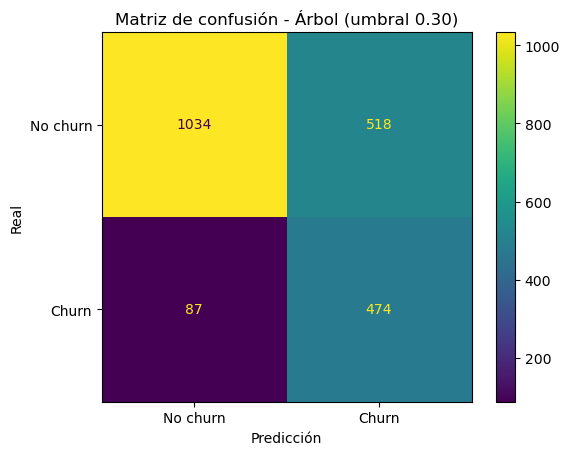

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_tree = confusion_matrix(y_test, y_pred_tree_030)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_tree,
    display_labels=["No churn", "Churn"]
)

plt.figure(figsize=(5, 5))
disp.plot(values_format="d")
plt.title("Matriz de confusión - Árbol (umbral 0.30)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


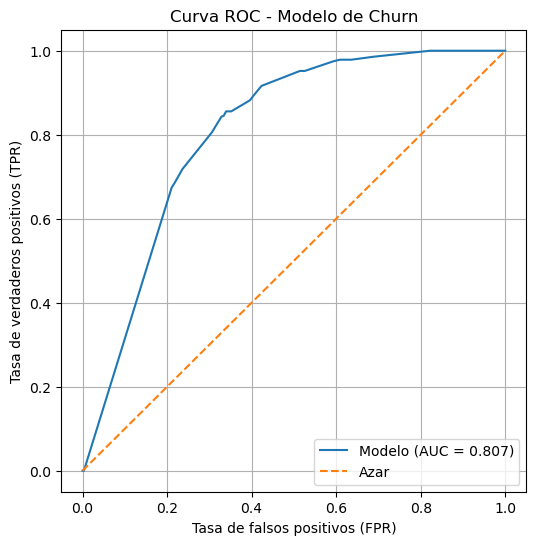

In [16]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_tree)
auc_value = roc_auc_score(y_test, y_proba_tree)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Modelo (AUC = {auc_value:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Modelo de Churn")
plt.legend()
plt.grid(True)
plt.show()

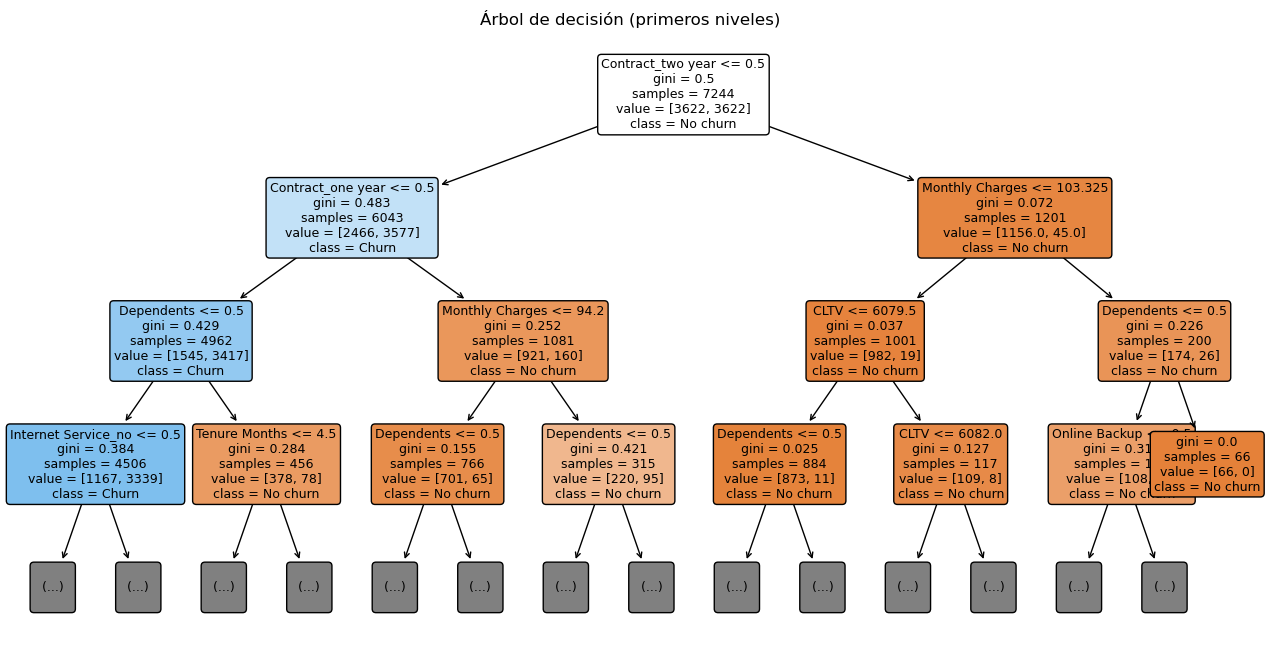

In [17]:
plt.figure(figsize=(16, 8))
plot_tree(
    tree_best,
    feature_names=X_train.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=3   # solo los 3 primeros niveles en el dibujo
)
plt.title("Árbol de decisión (primeros niveles)")
plt.show()


## MODELO ALTERNATIVO: RANDOM FOREST

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest base
rf_clf = RandomForestClassifier(
    n_estimators=300,     # número de árboles
    max_depth=None,      # que crezcan hasta donde quieran (el bosque suele aguantar bien)
    random_state=42,
    n_jobs=-1            # usar todos los núcleos disponibles
)

# Entrenamos
rf_clf.fit(X_train, y_train)

# Probabilidades de churn
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Predicción con el MISMO umbral 0.30
umbral = 0.30
y_pred_rf_030 = (y_proba_rf >= umbral).astype(int)

# Métricas
auc_rf = roc_auc_score(y_test, y_proba_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf_030)
acc_rf = accuracy_score(y_test, y_pred_rf_030)

tn, fp, fn, tp = cm_rf.ravel()
sens_rf = tp / (tp + fn)
esp_rf  = tn / (tn + fp)

print("ROC-AUC Random Forest:", auc_rf)
print("Matriz de confusión (RF, umbral 0.30):")
print(cm_rf)
print("Accuracy:", acc_rf)
print("Sensibilidad (churn):", sens_rf)
print("Especificidad (no churn):", esp_rf)


ROC-AUC Random Forest: 0.8385000321590678
Matriz de confusión (RF, umbral 0.30):
[[1189  363]
 [ 135  426]]
Accuracy: 0.7643161381921438
Sensibilidad (churn): 0.7593582887700535
Especificidad (no churn): 0.7661082474226805


In [19]:
# Importancias del Random Forest
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_clf.feature_importances_
})

# Ordenamos de mayor a menor importancia
importances = importances.sort_values("importance", ascending=False)

# Miramos las 15 más importantes
importances.head(15)


,feature,importance
4,Tenure Months,0.195795
14,Monthly Charges,0.169975
15,CLTV,0.153856
16,Internet Service_fiber optic,0.044639
3,Dependents,0.041644
21,Payment Method_electronic check,0.039573
19,Contract_two year,0.035628
0,Gender,0.027517
13,Paperless Billing,0.026494
18,Contract_one year,0.025675


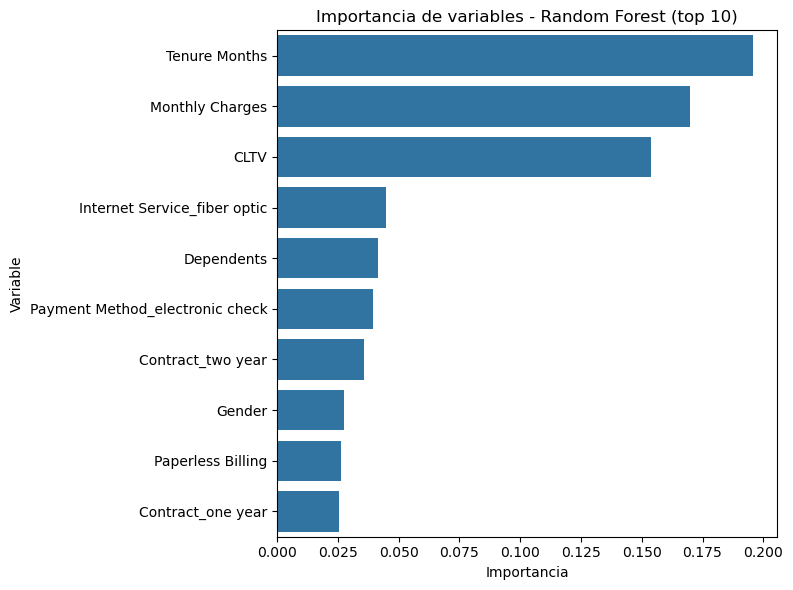

In [20]:
top_n = 10  # puedes cambiar a 15 si quieres

plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances.head(top_n),
    x="importance",
    y="feature"
)
plt.title(f"Importancia de variables - Random Forest (top {top_n})")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


## Comparamos modelos en un DataFrame

In [21]:
resultados_modelos = pd.DataFrame([
    {
        "modelo": "Random Forest",
        "roc_auc": 0.8385000322,
        "accuracy": 0.7643161382,
        "sensibilidad_churn": 0.7593582888,
        "especificidad_no_churn": 0.7661082474,
        "tn": 1189, "fp": 363, "fn": 135, "tp": 426,
    },
    {
        "modelo": "Árbol (max_depth=5)",
        "roc_auc": 0.830,
        "accuracy": 0.7136772362,
        "sensibilidad_churn": 0.8449197861,
        "especificidad_no_churn": 0.6662371134,
        "tn": 1034, "fp": 518, "fn": 87, "tp": 474,
    },
    {
        "modelo": "Regresión logística",
        "roc_auc": 0.83758407299,
        "accuracy": 0.729,
        "sensibilidad_churn": 0.806,
        "especificidad_no_churn": 0.702,
        "tn": 1089, "fp": 463, "fn": 109, "tp": 452,
    }
])

resultados_modelos


,modelo,roc_auc,accuracy,sensibilidad_churn,especificidad_no_churn,tn,fp,fn,tp
0,Random Forest,0.838500,0.764316,0.759358,0.766108,1189,363,135,426
1,Árbol (max_depth=5),0.830000,0.713677,0.844920,0.666237,1034,518,87,474
2,Regresión logística,0.837584,0.729000,0.806000,0.702000,1089,463,109,452


In [22]:
umbral = 0.30

# 1. Regresión logística
y_proba_log = y_proba               # ya la tenías como log_reg.predict_proba(...)[:, 1]
y_pred_logreg_030 = (y_proba_log >= umbral).astype(int)

# 2. Árbol
y_pred_tree_030 = (y_proba_tree >= umbral).astype(int)

# 3. Random Forest
y_pred_rf_030 = (y_proba_rf >= umbral).astype(int)


In [23]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg_030)
cm_tree   = confusion_matrix(y_test, y_pred_tree_030)
cm_rf     = confusion_matrix(y_test, y_pred_rf_030)

cm_logreg, cm_tree, cm_rf


(array([[1089,  463],
        [ 109,  452]], dtype=int64),
 array([[1034,  518],
        [  87,  474]], dtype=int64),
 array([[1189,  363],
        [ 135,  426]], dtype=int64))

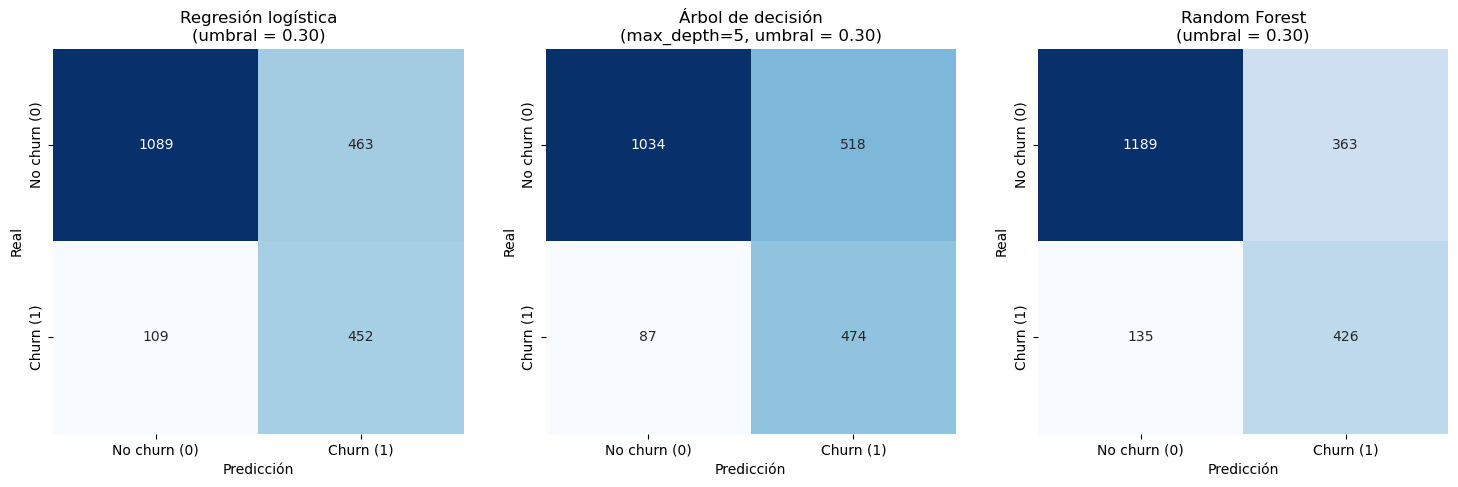

In [26]:
labels_pred = ["No churn (0)", "Churn (1)"]
labels_real = ["No churn (0)", "Churn (1)"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

modelos = [
    ("Regresión logística\n(umbral = 0.30)", cm_logreg),
    ("Árbol de decisión\n(max_depth=5, umbral = 0.30)", cm_tree),
    ("Random Forest\n(umbral = 0.30)", cm_rf),
]

for ax, (titulo, cm) in zip(axes, modelos):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels_pred,
        yticklabels=labels_real,
        cbar=False,
        ax=ax
    )
    ax.set_title(titulo)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout
plt.savefig("matrix_confusion.svg", bbox_inches="tight")
plt.show()


In [25]:
# Probabilidades logística
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Probabilidades árbol
y_proba_tree = tree_best.predict_proba(X_test)[:, 1]

# Probabilidades Random Forest
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]


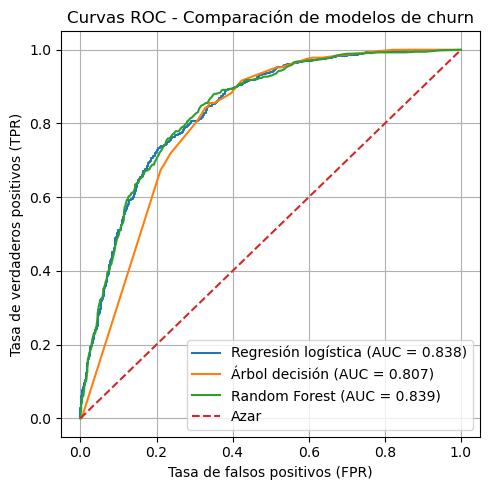

In [27]:
# Curvas ROC
fpr_log,  tpr_log,  _ = roc_curve(y_test, y_proba_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
fpr_rf,   tpr_rf,   _ = roc_curve(y_test, y_proba_rf)

# AUCs
auc_log  = roc_auc_score(y_test, y_proba_log)
auc_tree = roc_auc_score(y_test, y_proba_tree)
auc_rf   = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(5, 5))

plt.plot(fpr_log,  tpr_log,  label=f"Regresión logística (AUC = {auc_log:.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Árbol decisión (AUC = {auc_tree:.3f})")
plt.plot(fpr_rf,   tpr_rf,   label=f"Random Forest (AUC = {auc_rf:.3f})")

# Línea de azar
plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")

plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC - Comparación de modelos de churn")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_auc.svg", bbox_inches="tight")
plt.show()


### Análisis: Si estuvieramos buscando un modelo equilibrado, seguramente nos quedaríamos con la regresión logística, que subiendo el umbral incluso podría tener mejores valores de roc-auc y accuracy. 
### Pero como estamos interesados principalmente en no perder de vista a los clientes que se van, priorizamos la sensibilidad y nos quedamos con el modelo de Arbol. 

##### “Nuestro objetivo principal es detectar el máximo número posible de clientes que se van (minimizar falsos negativos), aunque eso implique molestar a algunos que no se irían (falsos positivos).

##### Comparando modelos en el set de test, el árbol de decisión con umbral 0.30 ofrece la mayor sensibilidad (≈ 0.84), aunque sacrifica algo de especificidad y de AUC frente a los otros modelos.

##### Por tanto, si priorizamos la detección de churn por encima de la precisión global, elegimos el árbol con ese umbral como modelo operativo, siendo conscientes de que en otros conjuntos de datos el orden podría variar.”

## Distribución de las probabilidades predichas de churn

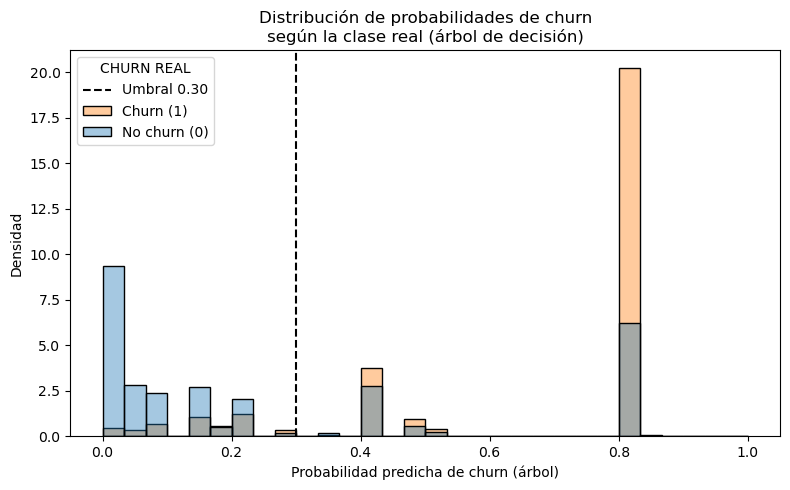

In [25]:
# DataFrame con probabilidades y clase real
df_prob = pd.DataFrame({
    "prob_churn_tree": y_proba_tree,
    "churn_real": y_test.values
})

plt.figure(figsize=(8, 5))

sns.histplot(
    data=df_prob,
    x="prob_churn_tree",
    hue="churn_real",
    bins=30,
    stat="density",
    common_norm=False,
    alpha=0.4
)

# Línea vertical en el umbral 0.30
plt.axvline(0.30, color="black", linestyle="--", label="Umbral 0.30")

plt.xlabel("Probabilidad predicha de churn (árbol)")
plt.ylabel("Densidad")
plt.title("Distribución de probabilidades de churn\nsegún la clase real (árbol de decisión)")
plt.legend(title="CHURN REAL", labels=["Umbral 0.30", "Churn (1)", "No churn (0)"])
plt.tight_layout()
plt.savefig("prob_distribution.svg", bbox_inches="tight")
plt.show()
